In [4]:
# Import necessary libraries
import requests  # For making API requests
import matplotlib.pyplot as plt  # For visualizations
from datetime import datetime  # For date and time functions
import numpy as np

weather_api_key = "KPwCveD9wOiNBUncND7WsKLVveMBXvHr"

In [5]:
# Function to get user location using their IP address
# It fetches the city, country, latitude, and longitude of the user
def get_user_location():
    ip_lookup_url = "https://ipinfo.io/json"
    response = requests.get(ip_lookup_url)
    if response.status_code == 200:
        data = response.json()
        city = data.get('city', 'Unknown')
        country = data.get('country', 'Unknown')
        loc = data.get('loc', None)  # 'loc' contains latitude and longitude as 'lat,lon'
        if loc:
            lat, lon = map(float, loc.split(','))
            return city, country, lat, lon
        else:
            return city, country, None, None
    else:
        return None, None, None, None


In [6]:
# Function to fetch weather data using Tomorrow.io API
# It retrieves temperature, wind speed, humidity, and precipitation data
def get_weather_data(lat, lon):
    weather_url = f"https://api.tomorrow.io/v4/timelines?location={lat},{lon}&fields=temperature,precipitationType,windSpeed,humidity&timesteps=1h&units=metric&apikey={weather_api_key}"
    response = requests.get(weather_url)

    if response.status_code == 200:
        data = response.json()
        intervals = data['data']['timelines'][0]['intervals']
        temperatures = [interval['values']['temperature'] for interval in intervals]
        humidity = [interval['values']['humidity'] for interval in intervals]
        wind_speed = [interval['values']['windSpeed'] for interval in intervals]
        precipitation = intervals[0].get('values').get('precipitationType', None)
        return temperatures, wind_speed, humidity, precipitation, intervals
    else:
        return None, None, None, None, None

In [7]:
def plot_graph(temperatures, humidity, wind_speed):
    # Create a figure and set of subplots
    time_intervals = np.arange(len(temperatures)
                               )
    fig, ax1 = plt.subplots(figsize=(10, 6))

    # Plot temperature on the primary y-axis
    ax1.set_xlabel('Time Intervals')
    ax1.set_ylabel('Temperature (°C)', color='tab:red')
    temp_line, = ax1.plot(time_intervals, temperatures, color='tab:red', label='Temperature', linewidth=2)
    ax1.tick_params(axis='y', labelcolor='tab:red')

    # Plot the average temperature as a horizontal line
    avg_temperature = np.mean(temperatures)
    avg_temp_line = ax1.axhline(avg_temperature, color='tab:red', linestyle='--', linewidth=1, label=f'Avg Temp: {avg_temperature:.2f}°C')

    # Add humidity on the secondary y-axis
    ax2 = ax1.twinx()
    ax2.set_ylabel('Humidity (%)', color='tab:blue')
    humidity_line, = ax2.plot(time_intervals, humidity, color='tab:blue', label='Humidity', linestyle='--', linewidth=2)
    ax2.tick_params(axis='y', labelcolor='tab:blue')

    # Plot the average humidity as a horizontal line
    avg_humidity = np.mean(humidity)
    avg_humidity_line = ax2.axhline(avg_humidity, color='tab:blue', linestyle='--', linewidth=1, label=f'Avg Humidity: {avg_humidity:.2f}%')

    # Add wind speed as a bar chart
    ax3 = ax1.twinx()
    ax3.spines['right'].set_position(('outward', 60))  # Move third axis outwards
    ax3.set_ylabel('Wind Speed (km/h)', color='tab:green')
    wind_bar = ax3.bar(time_intervals, wind_speed, alpha=0.3, color='tab:green', label='Wind Speed')
    ax3.tick_params(axis='y', labelcolor='tab:green')

    # Plot the average wind speed as a horizontal line
    avg_wind_speed = np.mean(wind_speed)
    avg_wind_speed_line = ax3.axhline(avg_wind_speed, color='tab:green', linestyle='--', linewidth=1, label=f'Avg Wind Speed: {avg_wind_speed:.2f} km/h')

    # Combine legends from all axes
    lines = [temp_line, avg_temp_line, humidity_line, avg_humidity_line]
    labels = [line.get_label() for line in lines]

    # For bar chart we add a proxy artist since bars do not directly show in legend
    wind_bar_proxy = plt.Rectangle((0, 0), 1, 1, fc="green", alpha=0.3)
    labels.append(f'Avg Wind Speed: {avg_wind_speed:.2f} km/h')

    # Adding the legend
    ax1.legend(lines + [wind_bar_proxy], labels, loc='upper left')

    # Add a title and finalize the layout
    plt.title('Weather Data Overview')
    fig.tight_layout()

    # Display the plot
    plt.show()

In [8]:
# Function to recommend an outfit based on weather conditions
# Uses emojis for visual representation of weather-related recommendations
def recommend_outfit(temperature, wind_speed, humidity, precipitation):
    # Using emojis for different weather conditions
    if precipitation == 1:  # Assuming 1 is rain in Tomorrow.io API
        outfit = "☔ It looks like it might rain today. A waterproof jacket or umbrella will keep you dry. Don't forget waterproof shoes!"
    elif temperature < 10:
        outfit = f"❄ It's chilly today at {temperature}°C. Layer up with a cozy sweater, a warm coat, and scarf. The wind speed is {wind_speed} km/h, so a windbreaker is also a good idea."
    elif 10 <= temperature < 20:
        if wind_speed > 20:
            outfit = f"🌬 It's a cool day at {temperature}°C, with high wind speeds of {wind_speed} km/h. A light jacket and windbreaker are perfect to keep you warm."
        else:
            outfit = f"🍂 The average temperature is {temperature}°C, and it's mildly windy at {wind_speed} km/h. A comfortable outfit with jeans and a jacket will be great."
    elif 20 <= temperature < 30:
        if humidity > 70:
            outfit = f"🌞 It's warm today at {temperature}°C, with humidity levels at {humidity}%. Opt for breathable fabrics like cotton to stay cool."
        else:
            outfit = f"☀ The average temperature is {temperature}°C, with moderate wind. A t-shirt, shorts, and sunglasses will keep you comfortable throughout the day."
    else:
        if humidity > 70:
            outfit = f"🔥 It's hot and humid today at {temperature}°C and humidity at {humidity}%. Stay cool with light, breathable fabrics and keep hydrated!"
        else:
            outfit = f"☀ It's hot today at {temperature}°C. Light clothing like cotton or linen will keep you cool. Don't forget your sunglasses and a hat."
    return outfit

# Function to display weather and outfit recommendation in markdown format
def display_weather_based_recommendation(city, country, temperature, wind_speed, humidity, precipitation)->str:
    # Display the weather details
    weather_details = f"""## Current Weather Details in {city}, {country}:\n- 🌡 **Temperature:** {temperature}°C
    - 🌬 **Wind Speed:** {wind_speed} km/h
    - 💧 **Humidity:** {humidity}%
    - 💧 **Precipitation:** {precipitation} mm
    """
    # Display the outfit recommendation
    outfit_recommendation = recommend_outfit(temperature, wind_speed, humidity, precipitation)
    
    outfit_details = f"""## Recommended Outfit:
    {outfit_recommendation}
    """
    
    # Final message
    final_message = """### Have a great day! 
    No matter what the weather is like, being prepared with the right clothing will help you enjoy it to the fullest.
    """
    
    # Printing the markdown output
    return f"{weather_details}\n\n{outfit_details}\n\n{final_message}"


In [9]:
# Import markdown display function
from IPython.display import Markdown
# Get user location
city, country, lat, lon = get_user_location()

# Get weather data based on location
if lat is not None and lon is not None:
    temperatures, wind_speed, humidity, precipitation, intervals = get_weather_data(lat, lon)

# Function to calculate the mean for each weather element
mean = lambda x: sum(x) // len(x)

# Display the weather-based recommendation using markdown
markdown_output = display_weather_based_recommendation(city, country, mean(temperatures), mean(wind_speed), mean(humidity), precipitation)
Markdown(markdown_output)

## Current Weather Details in New York City, US:
- 🌡 **Temperature:** 21.0°C
    - 🌬 **Wind Speed:** 2.0 km/h
    - 💧 **Humidity:** 67.0%
    - 💧 **Precipitation:** 0 mm
    

## Recommended Outfit:
    ☀ The average temperature is 21.0°C, with moderate wind. A t-shirt, shorts, and sunglasses will keep you comfortable throughout the day.
    

### Have a great day! 
    No matter what the weather is like, being prepared with the right clothing will help you enjoy it to the fullest.
    

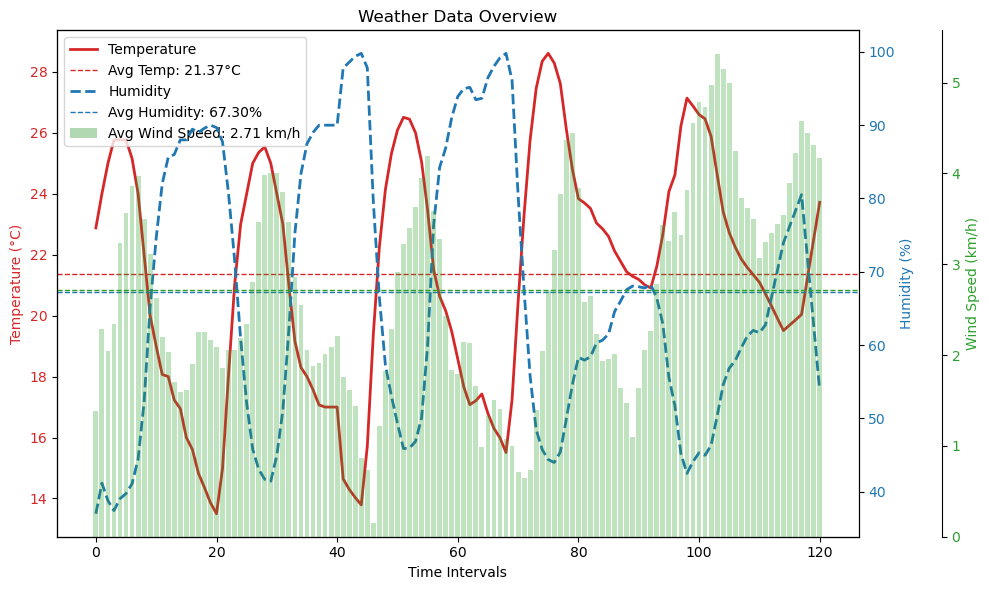

In [10]:
plot_graph(temperatures,humidity, wind_speed)